In [4]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=42
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [6]:
# data wrangling: load MNIST
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)

100.1%

Extracting /Users/moreez/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /Users/moreez/data/mnist/MNIST/raw


113.5%

Extracting /Users/moreez/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/moreez/data/mnist/MNIST/raw


100.4%

Extracting /Users/moreez/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/moreez/data/mnist/MNIST/raw


180.4%

Extracting /Users/moreez/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/moreez/data/mnist/MNIST/raw
Processing...
Done!


../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


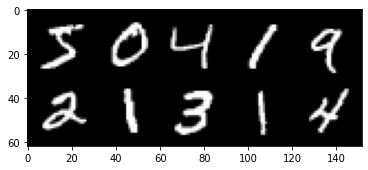

In [7]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = MNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))

In [8]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=128,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [9]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)

In [10]:
#set up the training routine
mnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
MNIST_PATH = "MNIST_weights.pth"

In [11]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

In [12]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(mnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(mnist_train_loader):
            output = mnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            mnist_train_optimizer.step()
            mnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(MNIST_PATH))
    torch.save(mnist_model.state_dict(), MNIST_PATH)

In [9]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)

In [13]:
#predict in distribution
MNIST_PATH = "MNIST_weights.pth"

mnist_model = NN(num_classes=10)
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

acc = []

max_len = len(mnist_test_loader)
for batch_idx, (x, y) in enumerate(mnist_test_loader):
        output = mnist_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))


loading model from: MNIST_weights.pth
Batch 0/79 	Accuracy 100%
Batch 10/79 	Accuracy 97%
Batch 20/79 	Accuracy 98%
Batch 30/79 	Accuracy 98%
Batch 40/79 	Accuracy 100%
Batch 50/79 	Accuracy 100%
Batch 60/79 	Accuracy 100%
Batch 70/79 	Accuracy 100%
overall test accuracy on MNIST: 99.13 %


# Laplace approximation of the weights
- we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
- we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian. 
- we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50). 

In [72]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [24]:
MNIST_NN_Cov_diag_000001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.00001,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [77]:
MNIST_NN_Std_prec_000001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.00001,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [25]:
print(MNIST_NN_Cov_diag_000001)

[tensor([[[[ 1811.5735,  1742.9844,  1928.4053,  2193.6604,  2976.2268],
          [ 2085.5635,  2041.3762,  2045.7375,  2623.4607,  3606.8948],
          [ 2207.9829,  2034.5148,  2090.4272,  2912.1169,  3456.8442],
          [ 2192.7754,  1903.4573,  2196.2505,  3291.6216,  3991.6616],
          [ 2063.6797,  1833.6844,  2299.7517,  3185.5779,  4292.6631]]],


        [[[ 4366.8257,  4138.7690,  3720.7700,  4219.5493,  6785.8105],
          [ 3601.8691,  3692.4954,  3738.1899,  4615.5244,  5585.2686],
          [ 3231.8523,  3157.9075,  3116.7473,  3471.5686,  3686.4148],
          [ 3953.5186,  3922.4653,  3180.0991,  2803.8689,  2901.1467],
          [ 5169.8809,  4444.2397,  3355.2896,  2853.0408,  3118.7476]]],


        [[[  757.2839,   495.8560,   313.6414,   256.6882,   294.1484],
          [  575.0914,   335.3869,   247.7607,   280.6552,   418.9444],
          [  395.8371,   260.9774,   267.9061,   473.1944,   855.2862],
          [  283.2436,   243.1515,   388.3549,   987.75

In [21]:
print(MNIST_NN_Std_diag_000001)

[tensor([[[[ 40.8566,  40.0937,  41.8295,  45.0487,  52.8562],
          [ 43.9503,  43.8381,  44.2221,  49.9107,  58.2450],
          [ 45.1658,  43.9080,  44.9916,  52.8997,  57.4893],
          [ 45.2120,  42.0944,  45.6361,  56.5630,  61.8920],
          [ 43.6281,  41.2036,  46.0585,  55.2082,  64.5245]]],


        [[[ 63.7212,  62.8346,  59.6343,  62.7568,  78.9888],
          [ 57.6109,  58.8936,  59.4931,  65.4501,  72.0667],
          [ 55.4370,  55.1287,  54.4761,  57.1220,  58.6710],
          [ 61.5068,  61.0146,  54.7368,  51.6912,  52.5440],
          [ 70.5860,  65.3934,  57.2109,  52.5644,  54.9553]]],


        [[[ 25.9302,  21.3123,  17.2247,  15.6724,  16.8654],
          [ 22.6739,  17.6777,  15.3950,  16.4246,  19.9561],
          [ 19.1922,  15.8355,  16.1259,  21.2666,  27.9278],
          [ 16.5451,  15.2677,  19.0956,  29.8475,  38.9040],
          [ 15.5905,  15.5446,  20.3174,  31.6005,  38.9923]]],


        [[[ 74.9017,  72.7410,  54.1426,  37.3943,  31.65

In [57]:
MNIST_NN_Cov_diag_1 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=1,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [58]:
print(MNIST_NN_Cov_diag_1)

[tensor([[[[0.9992, 0.9992, 0.9993, 0.9994, 0.9995],
          [0.9993, 0.9993, 0.9994, 0.9995, 0.9996],
          [0.9994, 0.9993, 0.9994, 0.9995, 0.9996],
          [0.9994, 0.9993, 0.9994, 0.9996, 0.9997],
          [0.9993, 0.9992, 0.9994, 0.9996, 0.9997]]],


        [[[0.9997, 0.9997, 0.9996, 0.9997, 0.9998],
          [0.9996, 0.9996, 0.9996, 0.9997, 0.9997],
          [0.9996, 0.9996, 0.9996, 0.9996, 0.9996],
          [0.9997, 0.9997, 0.9996, 0.9995, 0.9996],
          [0.9997, 0.9997, 0.9996, 0.9995, 0.9996]]],


        [[[0.9979, 0.9969, 0.9954, 0.9946, 0.9952],
          [0.9973, 0.9957, 0.9944, 0.9950, 0.9965],
          [0.9963, 0.9948, 0.9950, 0.9970, 0.9982],
          [0.9952, 0.9946, 0.9964, 0.9984, 0.9990],
          [0.9946, 0.9948, 0.9968, 0.9985, 0.9990]]],


        [[[0.9997, 0.9997, 0.9995, 0.9991, 0.9988],
          [0.9998, 0.9997, 0.9993, 0.9987, 0.9986],
          [0.9997, 0.9995, 0.9988, 0.9983, 0.9986],
          [0.9995, 0.9989, 0.9981, 0.9982, 0.9989],

In [14]:
MNIST_NN_Cov_diag_10 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=10,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [15]:
print(MNIST_NN_Cov_diag_10)

[tensor([[[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000]]],


        [[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000]]],


        [[[0.1000, 0.1000, 0.1000, 0.0999, 0.1000],
          [0.1000, 0.1000, 0.0999, 0.0999, 0.1000],
          [0.1000, 0.0999, 0.0999, 0.1000, 0.1000],
          [0.1000, 0.0999, 0.1000, 0.1000, 0.1000],
          [0.0999, 0.0999, 0.1000, 0.1000, 0.1000]]],


        [[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],

In [16]:
MNIST_NN_Cov_diag_100 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=100,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [17]:
print(MNIST_NN_Cov_diag_100)

[tensor([[[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100]]],


        [[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100]]],


        [[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100]]],


        [[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],

In [18]:
MNIST_NN_Cov_diag_1000 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=1000,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [19]:
print(MNIST_NN_Cov_diag_1000)

[tensor([[[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010]]],


        [[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010]]],


        [[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010]]],


        [[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],

# Plot the results
- We take the first ten datapoints from the test dataset.
- Draw 100 samples from the weight distribution do a forward pass for each and plot the resulting predictions.
- Repeat this procedure for prior precision 10, 20 and 50 (or variance of 1/10, 1/20, 1/50). 

In [21]:
#get the first ten datapoints from the test set
mnist_test_loader_10 = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=10,
    shuffle=False,
)

test_10_X, test_10_y = next(iter(mnist_test_loader_10))
print(test_10_X.size(), test_10_y.size())
print(test_10_y)

torch.Size([10, 1, 28, 28]) torch.Size([10])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


In [22]:
#take 100 samples from the distribution over the weights. 

def get_param_dists(Cov_Matr_diag):
    param_dists = []
    for idx, param in enumerate(mnist_model.parameters()):
        ps = param.size()
        mu = param.view(-1)
        Var = Cov_Matr_diag[idx].view(-1)
        sigmas = torch.sqrt(Var)
        print("mu size: ", mu.size())
        print("sigmas size: ", sigmas.size())
        dist = Normal(mu, sigmas)
        param_dists.append(dist)
        
    return(param_dists)

In [59]:
param_dists_01 = get_param_dists(MNIST_NN_Cov_diag_01)
param_dists_1 = get_param_dists(MNIST_NN_Cov_diag_1)
param_dists_10 = get_param_dists(MNIST_NN_Cov_diag_10)
param_dists_100 = get_param_dists(MNIST_NN_Cov_diag_100)
param_dists_1000 = get_param_dists(MNIST_NN_Cov_diag_1000)

mu size:  torch.Size([800])
sigmas size:  torch.Size([800])
mu size:  torch.Size([32])
sigmas size:  torch.Size([32])
mu size:  torch.Size([25600])
sigmas size:  torch.Size([25600])
mu size:  torch.Size([32])
sigmas size:  torch.Size([32])
mu size:  torch.Size([5120])
sigmas size:  torch.Size([5120])
mu size:  torch.Size([10])
sigmas size:  torch.Size([10])
mu size:  torch.Size([800])
sigmas size:  torch.Size([800])
mu size:  torch.Size([32])
sigmas size:  torch.Size([32])
mu size:  torch.Size([25600])
sigmas size:  torch.Size([25600])
mu size:  torch.Size([32])
sigmas size:  torch.Size([32])
mu size:  torch.Size([5120])
sigmas size:  torch.Size([5120])
mu size:  torch.Size([10])
sigmas size:  torch.Size([10])
mu size:  torch.Size([800])
sigmas size:  torch.Size([800])
mu size:  torch.Size([32])
sigmas size:  torch.Size([32])
mu size:  torch.Size([25600])
sigmas size:  torch.Size([25600])
mu size:  torch.Size([32])
sigmas size:  torch.Size([32])
mu size:  torch.Size([5120])
sigmas size

In [24]:
def get_stacked_results(param_dists, input_):

    num_samples = 100
    results = []

    mnist_test_model = NN(num_classes=10)
    mnist_test_model.eval()
    #new_state_dict = fmnist_model.state_dict()
    new_state_dict = dict()
    for s in range(num_samples):
        #torch.manual_seed(s)
        for idx, (p_name, param) in enumerate(mnist_model.named_parameters()):
            ps = param.size()
            new_weights = param_dists[idx].sample().view(ps)
            new_state_dict[p_name] = new_weights

        #print(new_state_dict.keys())
        mnist_test_model.load_state_dict(new_state_dict)
        y_pred_logits = mnist_test_model(input_)
        #print(y_pred_logits)
        y_pred = F.softmax(y_pred_logits, dim=1) 
        results.append(y_pred)

    stacked_results = torch.stack(results)
    return(stacked_results)

In [60]:
stacked_results_01 = get_stacked_results(param_dists_01, input_=test_10_X)
stacked_results_1 = get_stacked_results(param_dists_1, input_=test_10_X)
stacked_results_10 = get_stacked_results(param_dists_10, input_=test_10_X)
stacked_results_100 = get_stacked_results(param_dists_100, input_=test_10_X)
stacked_results_1000 = get_stacked_results(param_dists_1000, input_=test_10_X)

In [61]:
def plot_results_singular(stacked_results, num_bins=10, idx=0):

    for j in range(10):
        plt.hist(stacked_results[:,idx,j].detach().numpy(), range=[0,1], \
                           bins=num_bins, alpha=0.5, label='{}'.format(j))
        plt.legend()
        
    plt.show();

### plot singular results

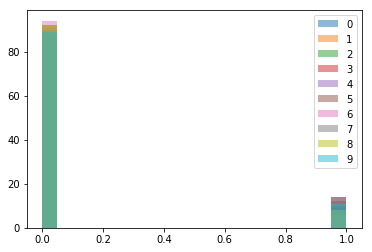

In [62]:
plot_results_singular(stacked_results_01, idx=0, num_bins=20)

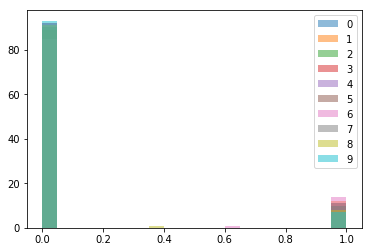

In [63]:
plot_results_singular(stacked_results_1, idx=0, num_bins=20)

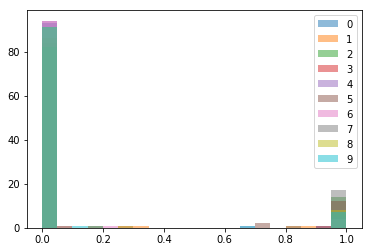

In [28]:
plot_results_singular(stacked_results_10, idx=0, num_bins=20)

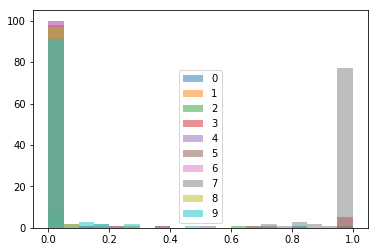

In [29]:
plot_results_singular(stacked_results_100, idx=0, num_bins=20)

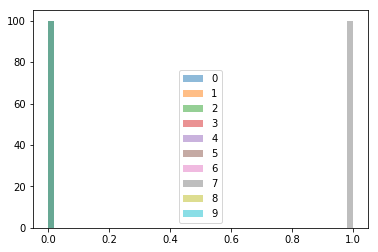

In [66]:
plot_results_singular(stacked_results_1000, idx=0, num_bins=50)

### plot multiple results

In [31]:
def plot_results_multiple(stacked_results, num_bins=10):
    fig, axs = plt.subplots(nrows=2, ncols=5, sharex=False, figsize=(26,6))

    for i in range(10):
        x = i // 5
        y = i % 5
        for j in range(10):
            axs[x][y].hist(stacked_results[:,i,j].detach().numpy(), range=[0,1], \
                           bins=num_bins, alpha=0.5, label='{}'.format(j))
            axs[x][y].legend()
        
    plt.show();

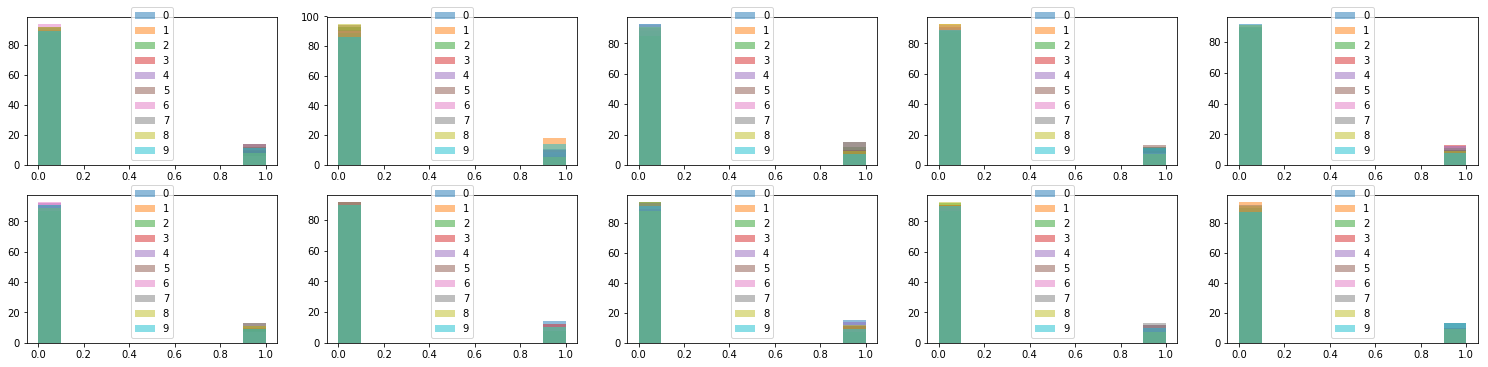

In [65]:
plot_results_multiple(stacked_results_01)

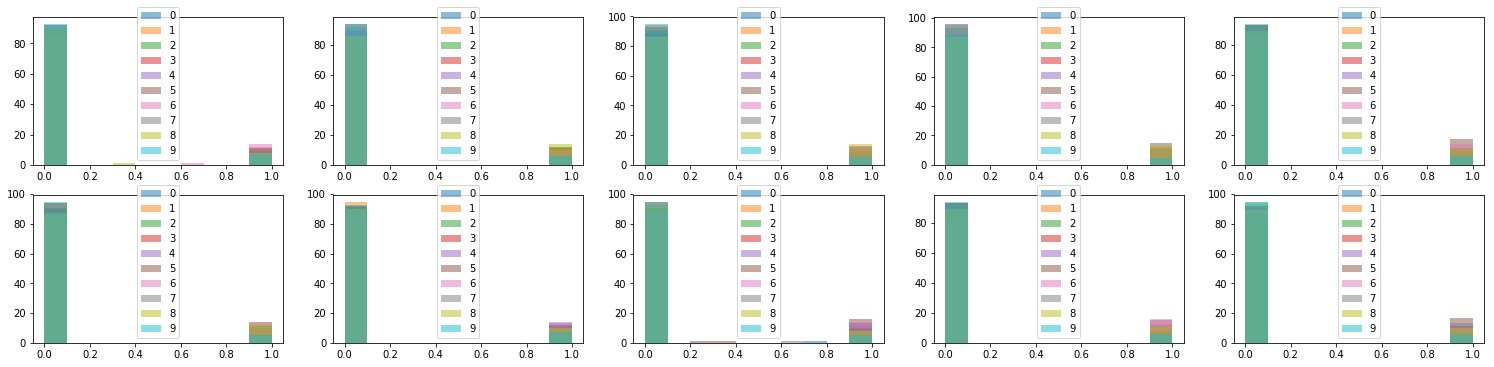

In [64]:
plot_results_multiple(stacked_results_1)

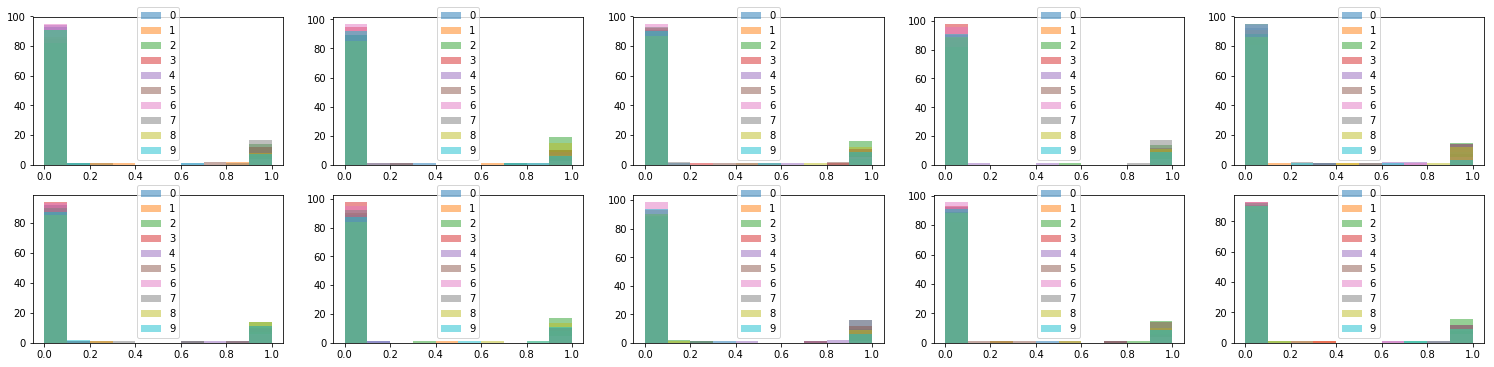

In [35]:
#plot the results for prior precision 10

plot_results_multiple(stacked_results_10)

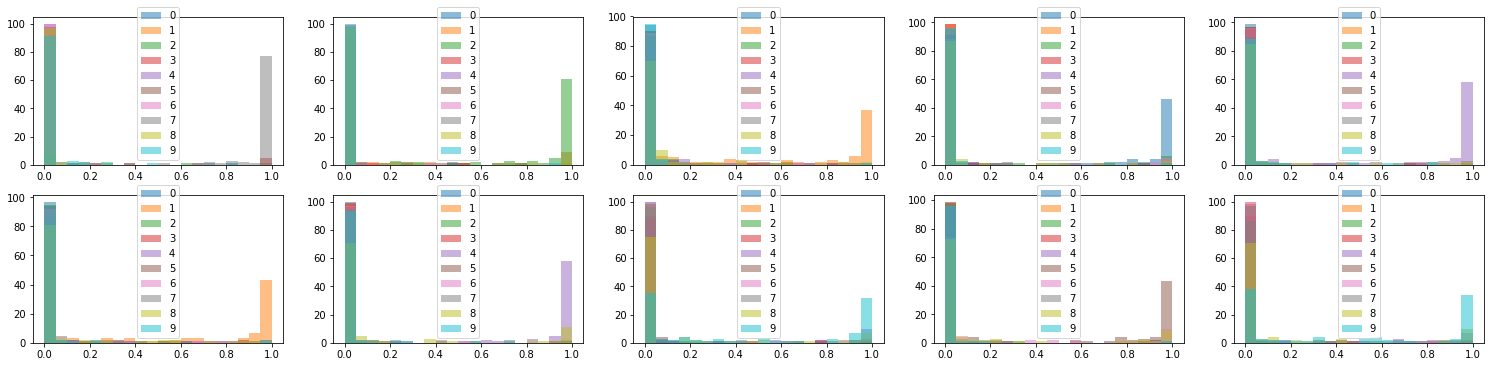

In [36]:
#plot the results for prior precision 20

plot_results_multiple(stacked_results_100, num_bins=20)

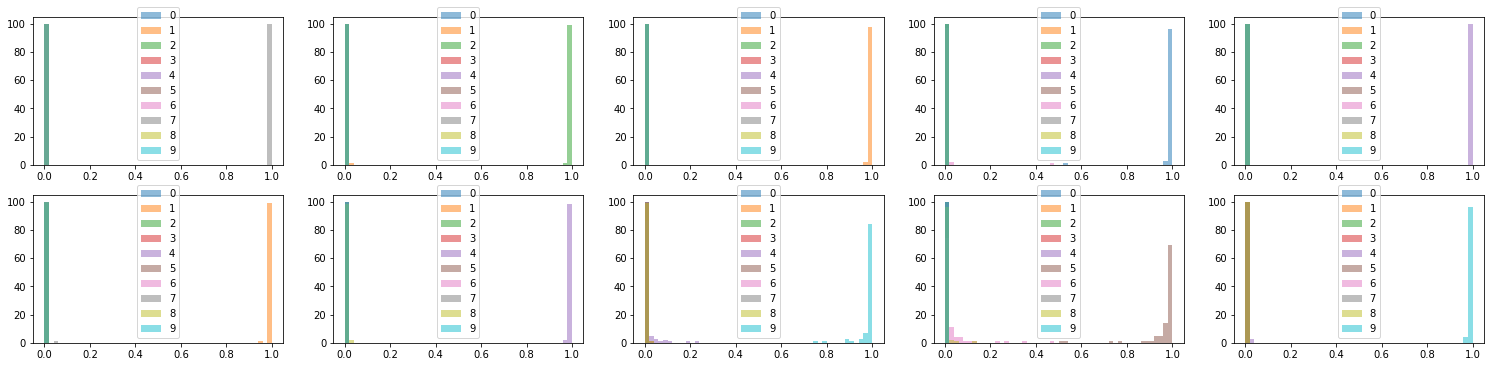

In [37]:
#plot the results for prior precision 50

plot_results_multiple(stacked_results_1000, num_bins=50)

# Why be Bayesian?

In this section we will test what the model does with data that do not belong to the distribution it was trained on (also known as out-of-distribution (OOD) data).
1. We will look at some numbers. AUROC, MMC, entropy, etc.
2. We test how results for a scaled version of MNIST look like
3. We test how results for White Noise look like
4. We test how results for Fashion MNIST look like

In [38]:
def get_in_dist_values(py_in, targets):
    acc_in = np.mean(np.argmax(py_in, 1) == targets)
    prob_correct = py_in[targets].mean()
    average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
    MMC = py_in.max(1).mean()
    return(acc_in, prob_correct, average_entropy, MMC)

def get_out_dist_values(py_in, py_out, targets):
    average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
    acc_out = np.mean(np.argmax(py_out, 1) == targets)
    if max(targets) > len(py_in[0]):
        targets = np.array(targets)
        targets[targets >= len(py_in[0])] = 0
    prob_correct = py_out[targets].mean()
    labels = np.zeros(len(py_in)+len(py_out), dtype='int32')
    labels[:len(py_in)] = 1
    examples = np.concatenate([py_in.max(1), py_out.max(1)])
    auroc = roc_auc_score(labels, examples)
    MMC = py_out.max(1).mean()
    return(acc_out, prob_correct, average_entropy, MMC, auroc)

def print_in_dist_values(acc_in, prob_correct, average_entropy, MMC, train='mnist', method='KFAC'):

    print(f'[In, {method}, {train}] Accuracy: {acc_in:.3f}; average entropy: {average_entropy:.3f}; \
    MMC: {MMC:.3f}; Prob @ correct: {prob_correct:.3f}')


def print_out_dist_values(acc_out, prob_correct, average_entropy, MMC, auroc, train='mnist', test='FMNIST', method='KFAC'):

    print(f'[Out-{test}, {method}, {train}] Accuracy: {acc_out:.3f}; Average entropy: {average_entropy:.3f};\
    MMC: {MMC:.3f}; AUROC: {auroc:.3f}; Prob @ correct: {prob_correct:.3f}')

torch.Size([10, 1, 28, 28]) torch.Size([10])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])


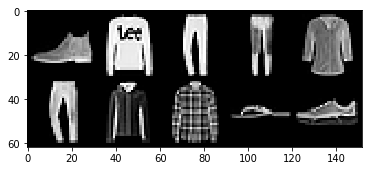

In [39]:
#set up Some FMNIST images
FMNIST_test = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=False,
        download=False,
        transform=MNIST_transform)

fmnist_test_loader = torch.utils.data.dataloader.DataLoader(
    FMNIST_test,
    batch_size=10,
    shuffle=False,
)

FMNIST_test_10_X, FMNIST_test_10_y = next(iter(fmnist_test_loader))
print(FMNIST_test_10_X.size(), FMNIST_test_10_y.size())
print(FMNIST_test_10_y)

FMNIST_images = FMNIST_test.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(FMNIST_images, nrow=5))

In [40]:
from sklearn.metrics import roc_auc_score
targets = FMNIST_test.targets.numpy()

In [41]:
MNIST_in = []
for x,y in mnist_test_loader:
    out_ = mnist_model(x).detach()
    out = F.softmax(out_, dim=1) 
    MNIST_in.append(out)
MNIST_in = torch.cat(MNIST_in, dim=0).cpu().numpy()

In [42]:
FMNIST_out = []
for x,y in fmnist_test_loader:
    out_ = mnist_model(x).detach()
    out = F.softmax(out_, dim=1) 
    FMNIST_out.append(out)
FMNIST_out = torch.cat(FMNIST_out, dim=0).cpu().numpy()

In [43]:
acc_FMNIST, prob_FMNIST, ent_FMNIST, MMC_FMNIST, auroc_FMNIST = get_out_dist_values(MNIST_in, FMNIST_out, targets)
print_out_dist_values(acc_FMNIST, prob_FMNIST, ent_FMNIST, MMC_FMNIST, auroc_FMNIST, method='MAP')

[Out-FMNIST, MAP, mnist] Accuracy: 0.064; Average entropy: 1.224;    MMC: 0.564; AUROC: 0.988; Prob @ correct: 0.100


## Scaled MNIST tests

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 28, 28])


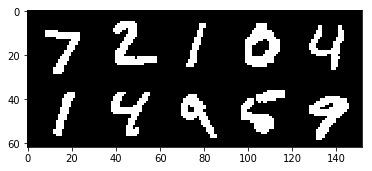

In [44]:
# set up some scaled FMNIST images
mnist_test_loader_10 = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=10,
    shuffle=False,
)

MNIST_test_10_X, MNIST_test_10_y = next(iter(mnist_test_loader_10))
MNIST_test_10_X_scaled = 1000 * MNIST_test_10_X
print(MNIST_test_10_X_scaled.size())

MNIST_images = MNIST_test_10_X_scaled.view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(MNIST_images, nrow=5))

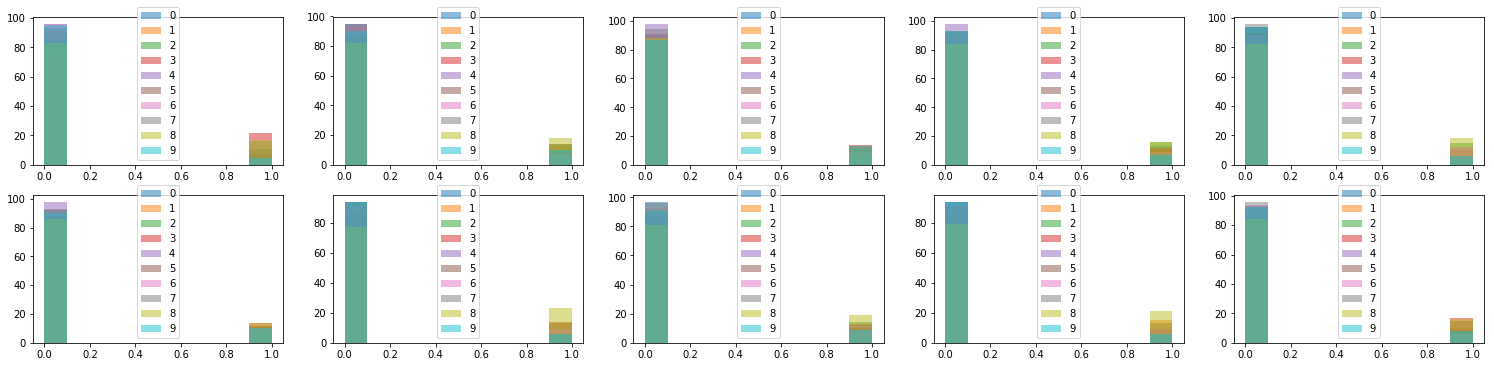

In [45]:
MNIST_stacked_results_10_scaled = get_stacked_results(param_dists_10, input_=MNIST_test_10_X_scaled)
plot_results_multiple(MNIST_stacked_results_10_scaled)

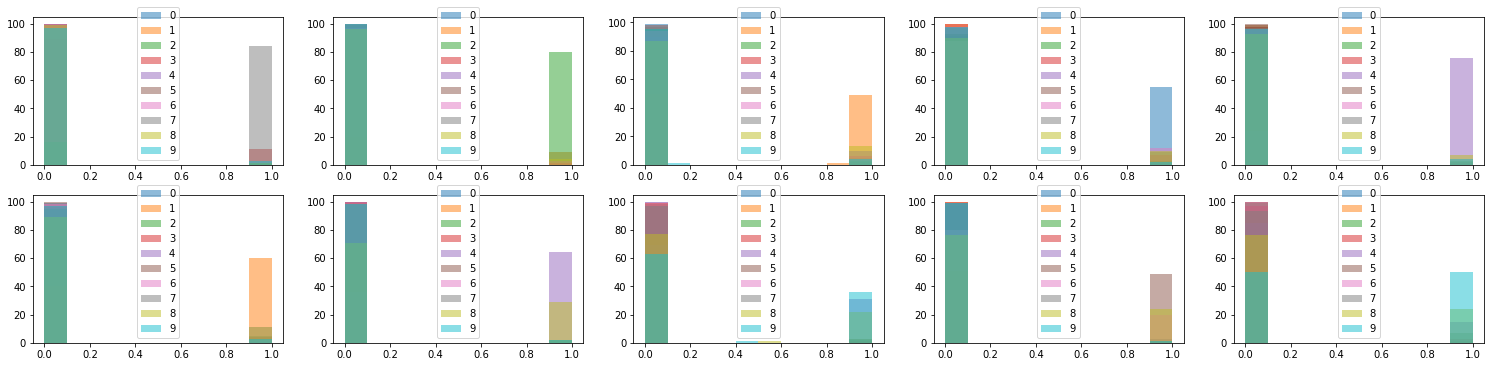

In [46]:
MNIST_stacked_results_100_scaled = get_stacked_results(param_dists_100, input_=MNIST_test_10_X_scaled)
plot_results_multiple(MNIST_stacked_results_100_scaled)

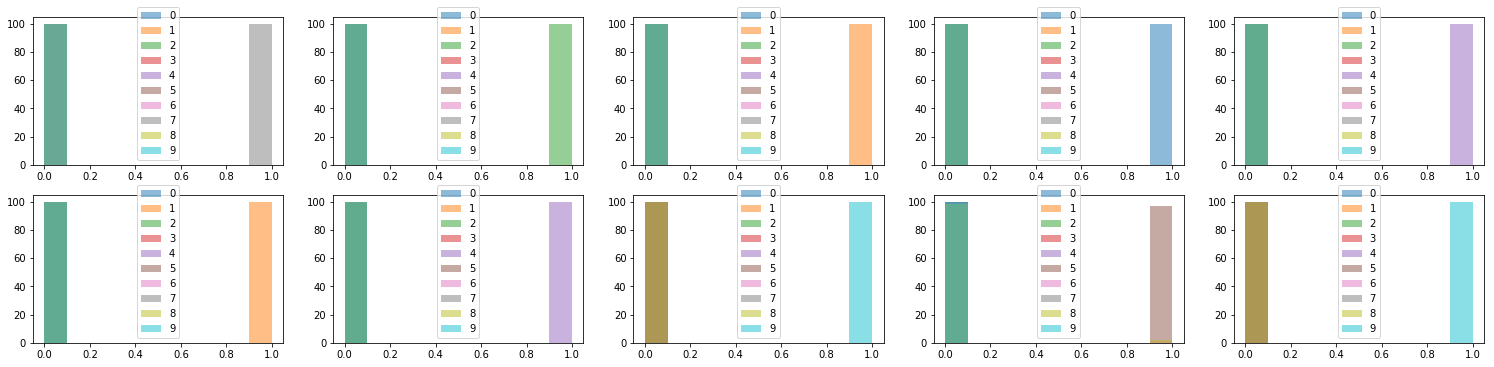

In [47]:
MNIST_stacked_results_1000_scaled = get_stacked_results(param_dists_1000, input_=MNIST_test_10_X_scaled)
plot_results_multiple(MNIST_stacked_results_1000_scaled)

## White noise test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


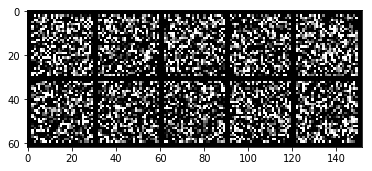

In [48]:
# set up some white noise images
white_noise_10 = torch.empty((10,1,28,28)).normal_(mean=0,std=1)
imshow(torchvision.utils.make_grid(white_noise_10, nrow=5))

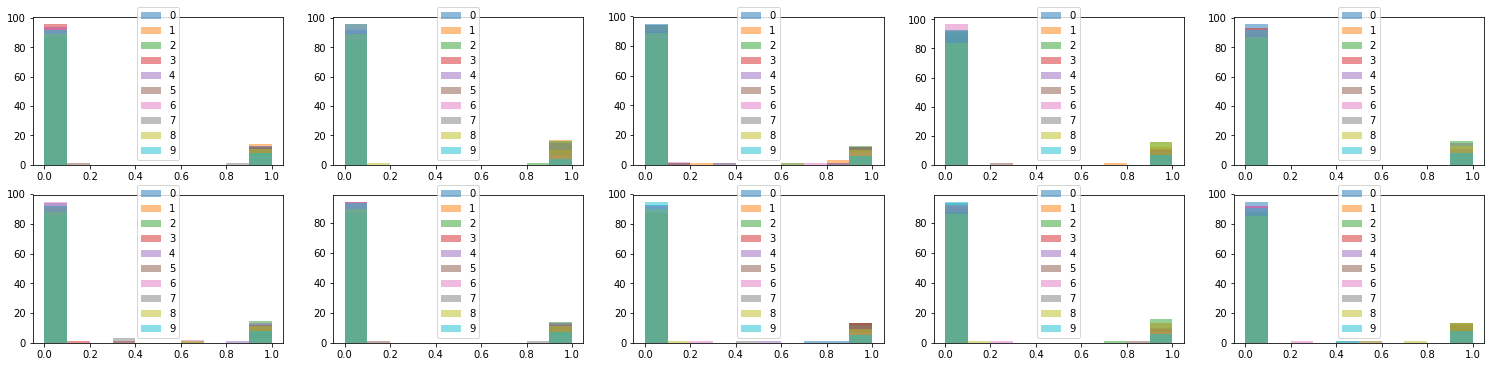

In [49]:
WN_stacked_results_10 = get_stacked_results(param_dists_10, input_=white_noise_10)
plot_results_multiple(WN_stacked_results_10, num_bins=10)

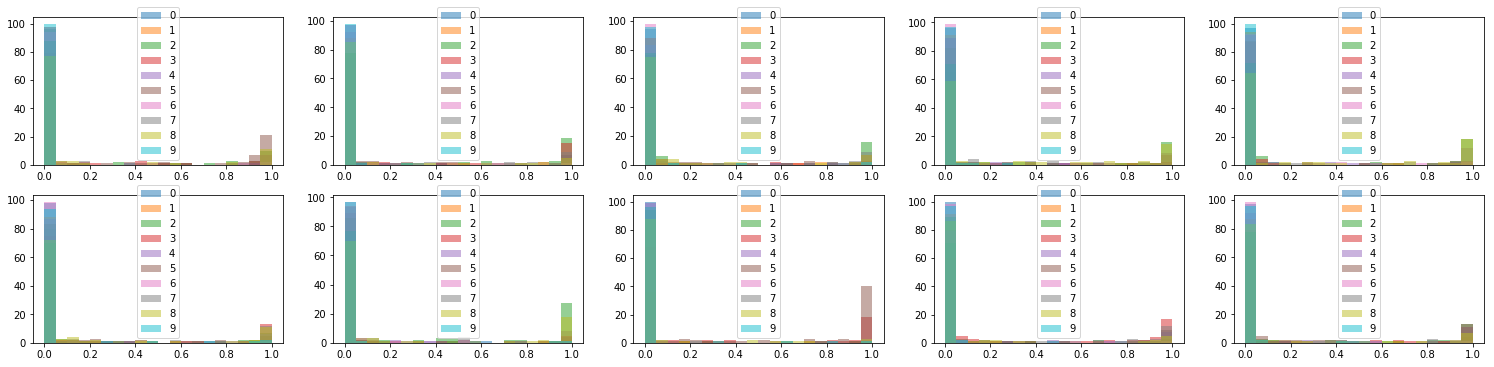

In [50]:
WN_stacked_results_100 = get_stacked_results(param_dists_100, input_=white_noise_10)
plot_results_multiple(WN_stacked_results_100, num_bins=20)

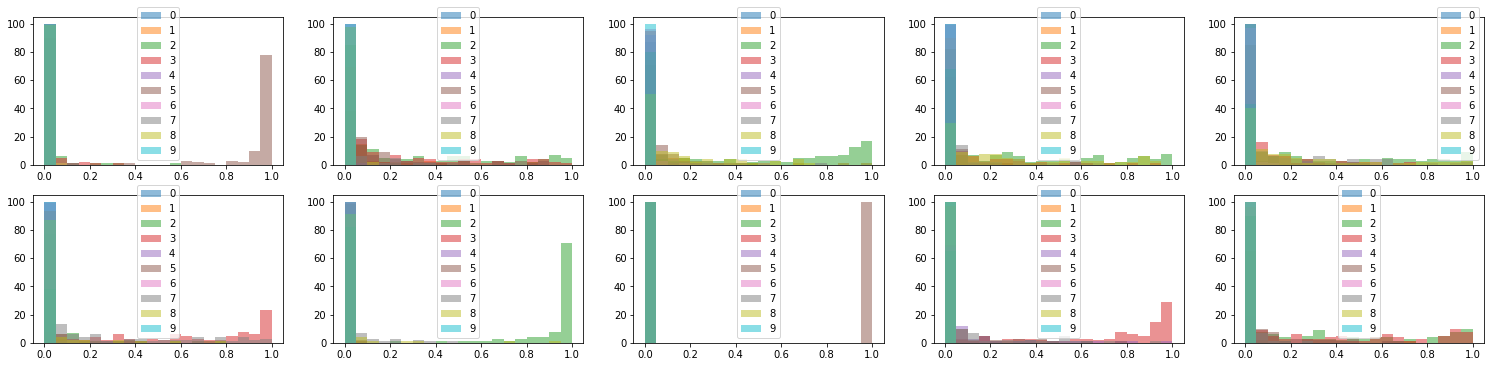

In [51]:
WN_stacked_results_1000 = get_stacked_results(param_dists_1000, input_=white_noise_10)
plot_results_multiple(WN_stacked_results_1000, num_bins=20)

## FMNIST OOD test

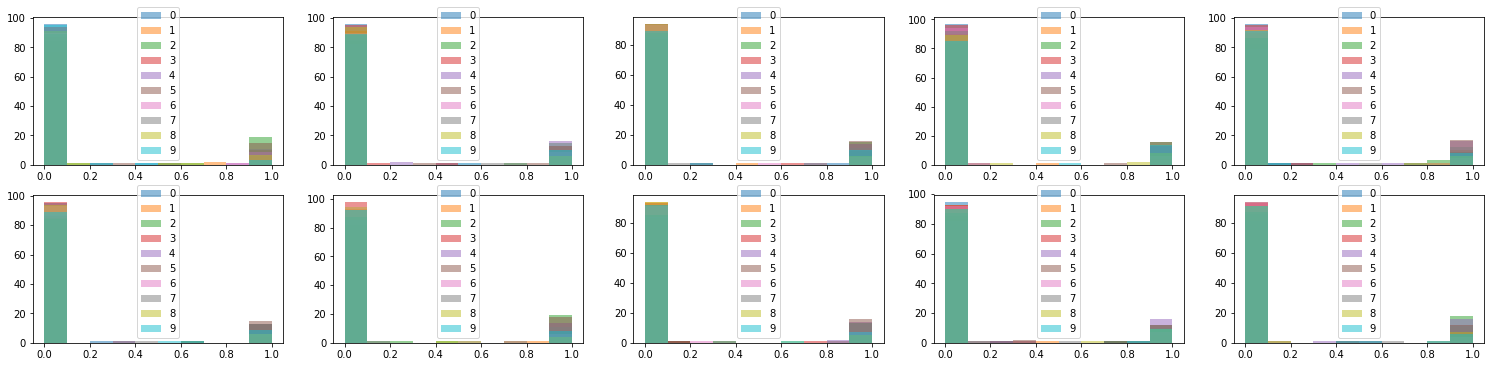

In [52]:
FMNIST_stacked_results_10 = get_stacked_results(param_dists_10, input_=FMNIST_test_10_X)
plot_results_multiple(FMNIST_stacked_results_10)

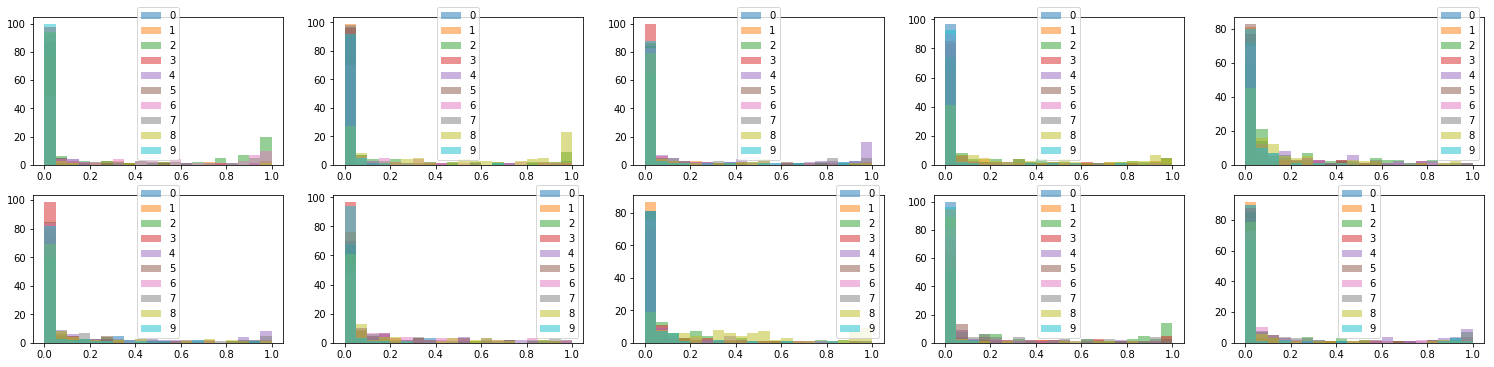

In [53]:
FMNIST_stacked_results_100 = get_stacked_results(param_dists_100, input_=FMNIST_test_10_X)
plot_results_multiple(FMNIST_stacked_results_100, num_bins=20)

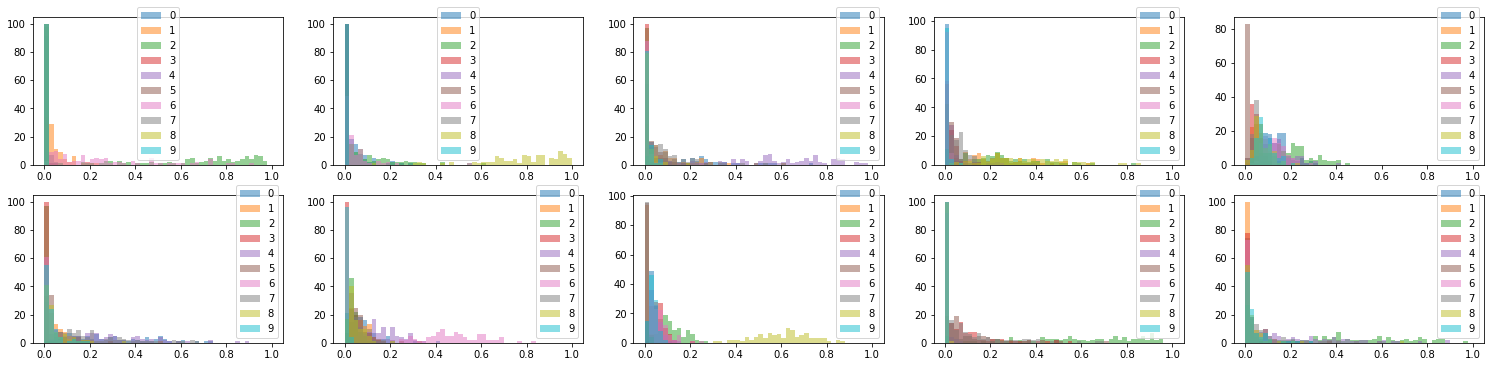

In [54]:
FMNIST_stacked_results_1000 = get_stacked_results(param_dists_1000, input_=FMNIST_test_10_X)
plot_results_multiple(FMNIST_stacked_results_1000, num_bins=50)

In [70]:
#plt.hist(MNIST_NN_Std_diag_000001[4])
#print(MNIST_NN_Std_diag_000001[4])

In [71]:
#plt.hist(MNIST_NN_Cov_diag_000001[4])

In [69]:
#for i in range(len(MNIST_NN_Std_diag_01[4])):
   # print(MNIST_NN_Std_diag_000001[4][i])

In [76]:
plt.imshow(MNIST_NN_Std_prec_000001[4], cmap='gist_stern',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
plt.savefig('linear_seed1000={}'.format(s))

plt.hist(MNIST_NN_Std_diag_000001[4])

NameError: name 'MNIST_NN_Std_prec_000001' is not defined

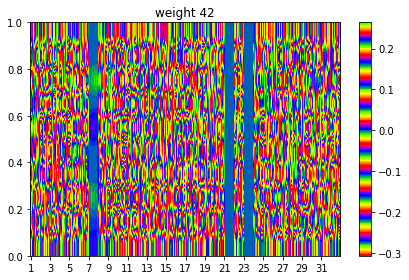

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 1., ..., 1., 1., 0.],
        [0., 0., 1., ..., 2., 0., 0.],
        [0., 0., 2., ..., 1., 0., 0.]]),
 array([-0.30712116, -0.25001156, -0.19290197, -0.13579236, -0.07868277,
        -0.02157317,  0.03553643,  0.09264603,  0.14975563,  0.20686522,
         0.26397482], dtype=float32),
 <a list of 512 Lists of Patches objects>)

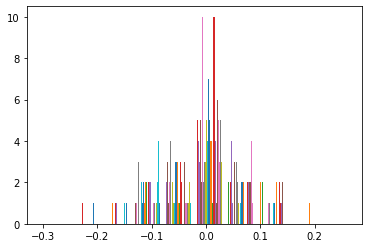

In [65]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        params = parameters

params_arr = params.detach().numpy()

plt.imshow(params_arr, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('weight {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
plt.hist(params_arr)

(array([[ 0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  8.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  5.,  8.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  4.,  1.,  2.,  5.,  0.,  2.,  1.],
        [ 0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([-7.4455173e-05, -3.5840156e-05,  2.7748640e-06,  4.1389882e-05,
         8.0004902e-05,  1.1861992e-04,  1.5723494e-04,  1.9584995e-04,
         2.3446497e-04,  2.7307999e-04,  3.1169501e-04], dtype=float32),
 <a list of 10 Lists of Patches objects>)

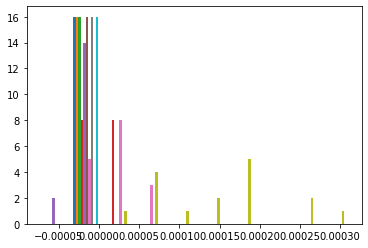

In [73]:
to_hist = []
target_feature = 23
for i in range(10):
    weight = params[i].detach().numpy()
    weight = np.array_split(np.array(weight), 32)
    to_hist.append(weight[target_feature -1])
plt.hist(to_hist)

In [54]:
def meancalc2(Hessian_diag_x):
    i = 0 
    for name, parameter in mnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        print("mean std of layer {0:s}: {1:.4f}".format(name, mean.item()))
        i += 1

def weightmeans():
    i=0
    for name, parameter in mnist_model.named_parameters():
        mean = torch.mean(parameter)
        print("mean weight value of layer {0:s}: {1:.4f}".format(name, mean.item()))

In [55]:
meancalc2(MNIST_NN_Std_diag_000001)
weightmeans()

mean std of layer 0.weight: 42.8183
mean std of layer 0.bias: 19.8193
mean std of layer 3.weight: 121.9406
mean std of layer 3.bias: 65.3394
mean std of layer 7.weight: 73.4981
mean std of layer 7.bias: 32.8294
mean weight value of layer 0.weight: -0.0025
mean weight value of layer 0.bias: 0.0030
mean weight value of layer 3.weight: -0.0024
mean weight value of layer 3.bias: -0.0108
mean weight value of layer 7.weight: -0.0047
mean weight value of layer 7.bias: 0.0039
